### Inntak

Inntakið er stefnt net af Höfuðborgarsvæðinu, hver hnútur v táknar mót tveggja vega og
hefur auðkenni og staðsetningu, (x, y) hnit. Leggirnir (u, v) tákna vegi, þ.e. það er hægt að
keyra á frá u til v og á milli þessara hnúta er ekki hægt að taka neinar aðrar ákvarðanir í
umferðinni. Skráin nodes inniheldur upplýsingar um hnútana, edges inniheldur upplýsingar um vegina.

### Reiknirit

Ef við fáum gefinn lista af k hnútum þar sem settar hafa verið upp hleðslustöðvar, búið til
reiknirit sem reiknar stystu fjarlægð frá hnverjum hnúti v í einhverja hleðslustöð. Fjarlægðir
á leggjum eiga að vera mældar í metrum og þær eru reiknaðar út frá hnitum hnútanna.
Einfaldasta leiðin til að leysa þetta er að nota reiknirit dijkstra fyrir hverja hleðslustöð
en það er hægt að hraða því með því að setja upphafsfjarlægðirnar á skynsamlegan hátt.

## Verkþættir

### 1. Þáttun (⋆)

Lesið inn netið úr skránum sem eru gefnar, nodes.tsv og edges.tsv. Í skránni nodes.tsv
eru hnútar með auðkenni (id), hnit (x, y) og hvort þeir séu á aðalvegi (primary). Í skránni
edges.tsv eru leggi frá hnúti u til hnúts v með lengd length, mæld í metrum, og nafn
(name).

In [ ]:
pip install pandas

In [10]:
import pandas as pd

In [11]:
nodes = pd.read_csv("nodes.tsv", sep="\t")
edges = pd.read_csv("edges.tsv", sep="\t")

In [12]:
nodes.head()

,osmid,x,y,primary
0,12885866,-21.937473,64.067271,False
1,12885876,-21.939951,64.076157,True
2,12885922,-22.087890,64.031977,False
3,12885923,-21.937852,64.067260,False
4,12885924,-21.938078,64.067047,True


In [20]:
# number of lines in the nodes dataframe
print(len(nodes))

# number of lines in the edges dataframe
print(len(edges))

10983
22319


In [13]:
edges.head()

,u,v,length,name
0,12885866,12885923,18.992015,Hlíðartorg
1,12885866,1573411414,653.666145,Reykjanesbraut
2,12885876,1660480490,35.437064,Flatahraun
3,12885876,12885952,16.131272,FH-Torg
4,12885922,2978379988,2587.067864,Reykjanesbraut


### 2. Leit (⋆⋆)

Ef við setjum hleðslustöðvar á hnúta v1, . . . , vk þá er hægt að nota reikniritið dijkstra til að finna stystu fjarlægð frá hverjum hnúti u í hleðslustöð vi. Útfærið reikniritið sem tekur inn lista af lokahnútum og reiknar fjarlægðir frá öllum hnútum í netinu. 
Athugið að netið er stefnt net.

In [ ]:
pip install networkx

In [16]:
import networkx as nx

In [33]:
def shortest_path_to_charging_station(nodes, edges, charging_stations, start_nodes):

    """ Reiknirit sem reiknar stystu leið frá ákveðnum hnútum í netinu til hleðslustöðvanna
     
        Inntak:
        nodes: DataFrame með hnútum í netinu
        edges: DataFrame með leggjum í netinu
        charging_station: listi af lokahnútum sem eru hleðslustöðvar
        start_nodes: listi af upphafshnútum sem við viljum reikna leiðina frá

        Úttak:
        G: Stefnt net sem inniheldur stystu leiðirnar frá öllum hnútum í netinu til hleðslustöðvanna
    """
    
    # Búum til stefnt net
    G = nx.DiGraph()

    # Bætum við hnútum
    for _, row in nodes.iterrows():
        G.add_node(row["osmid"], x=row["x"], y=row["y"], primary=row["primary"])

    # Bætum við leggjum
    for _, row in edges.iterrows():
        G.add_edge(row["u"], row["v"], weight=row["length"])

    # Listi til að geyma niðurstöður
    results = []

    # Reiknum stystu leiðir frá hverjum upphafshnút til allra hleðslustöðva
    for node in start_nodes:
        for cs in charging_stations:
            if nx.has_path(G, node, cs):  # Athugum hvort leið sé til hleðslustöðvar
                distance = nx.shortest_path_length(G, source=node, target=cs, weight="weight")
                results.append({"start_node": node, "charging_station": cs, "distance": distance})
            else:
                results.append({"start_node": node, "charging_station": cs, "distance": float("inf")})  # Engin leið

    # Skilum niðurstöðum sem DataFrame
    return pd.DataFrame(results)



Hraðari útfærsla:

In [ ]:
def shortest_path_to_charging_station_faster(nodes, edges, charging_stations, start_nodes):
    """Reiknirit sem reiknar stystu leið frá ákveðnum hnútum í netinu til hleðslustöðvanna."""
    
    # Búum til stefnt net
    G = nx.DiGraph()

    # Bætum við hnútum
    for _, row in nodes.iterrows():
        G.add_node(row["osmid"], x=row["x"], y=row["y"], primary=row["primary"])

    # Bætum við leggjum
    for _, row in edges.iterrows():
        G.add_edge(row["u"], row["v"], weight=row["length"])

    # Reverse the graph to calculate shortest paths from charging stations to all nodes
    G_reversed = G.reverse()

    # Use multi-source Dijkstra's algorithm from all charging stations
    distances = nx.multi_source_dijkstra_path_length(G_reversed, sources=charging_stations, weight="weight")

    # Collect results for the specified start nodes
    results = []
    for node in start_nodes:
        for cs in charging_stations:
            distance = distances.get(node, float("inf"))  # Get distance or infinity if unreachable
            results.append({"start_node": node, "charging_station": cs, "distance": distance})

    return pd.DataFrame(results)

### 3. Framsetning (⋆)

Setjið fimm hleðslustöðvar í netið og sýnið stystu leið fyrir fimm punkta og teiknið upp á kort. Tékkið ykkur af með því að bera saman leiðina sem er fundin og fjarlægðina miðað við kortavefi eins og t.d. Google Maps.

In [25]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [ ]:
# Veljum fimm hnúta þar sem við setjum hleðslustöð
charging_stations = [12885876, 111456955, 14586813, 26471955, 34187360]

# fimm hnútar sem við veljum
five_nodes = [34389202, 35295068, 253467906, 330050169, 27237169]

shortest_path_five = shortest_path_to_charging_station_faster(nodes, edges, charging_stations, five_nodes)


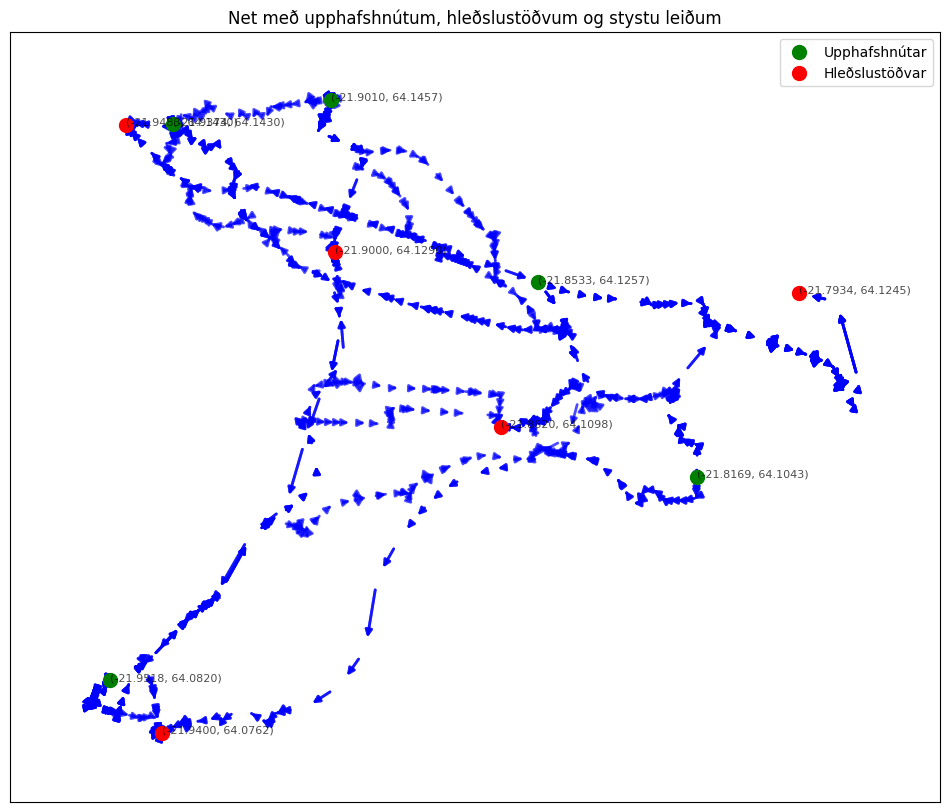

In [53]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes with attributes
for _, row in nodes.iterrows():
    G.add_node(row["osmid"], x=row["x"], y=row["y"], primary=row["primary"])

# Add edges with weights
for _, row in edges.iterrows():
    G.add_edge(row["u"], row["v"], weight=row["length"])

# Add nodes with positions
pos = {row["osmid"]: (row["x"], row["y"]) for _, row in nodes.iterrows()}

# Collect edges that are part of the shortest paths
shortest_path_edges = []
for _, row in shortest_path_five.iterrows():
    start_node = row["start_node"]
    charging_station = row["charging_station"]
    distance = row["distance"]

    if distance != float("inf"):  # Only include if a path exists
        path = nx.shortest_path(G, source=start_node, target=charging_station, weight="weight")
        shortest_path_edges.extend(list(zip(path[:-1], path[1:])))  # Add edges from the path

# Plot the graph
plt.figure(figsize=(12, 10))

# Highlight start nodes
nx.draw_networkx_nodes(
    G, pos, nodelist=five_nodes, node_color="green", node_size=100, label="Upphafshnútar"
)

# Highlight charging stations
nx.draw_networkx_nodes(
    G, pos, nodelist=charging_stations, node_color="red", node_size=100, label="Hleðslustöðvar"
)

# Draw only the edges in the shortest paths
nx.draw_networkx_edges(
    G, pos, edgelist=shortest_path_edges, edge_color="blue", width=2, alpha=0.7
)

# Annotate only the start nodes and charging stations
for node in five_nodes + charging_stations:
    x, y = pos[node]
    plt.text(x, y, f"({x:.4f}, {y:.4f})", fontsize=8, color="black", alpha=0.7)

# Add legend and title
plt.legend()
plt.title("Net með upphafshnútum, hleðslustöðvum og stystu leiðum")
plt.show()

### 4. Tímamælingar (⋆)

Mælið tímann sem reikniritið dijkstra tekur að reikna allar fjarlægðir í netinu með fimm hleðslustöðvum.

In [ ]:
# tekur ca 16 mínútur
shortest_path_all_slow = shortest_path_to_charging_station(nodes, edges, charging_stations, nodes["osmid"].tolist())

In [59]:
import time

start_time = time.time()

shortest_path_all_fast = shortest_path_to_charging_station_faster(nodes, edges, charging_stations, nodes["osmid"].tolist())

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Reiknirit Djikstra tók: {elapsed_time:.4f} sekúndur")

Reiknirit Djikstra tók: 0.6569 sekúndur


In [ ]:
shortest_path_all_fast.head()

,start_node,charging_station,distance
0,12885866,12885876,1001.407165
1,12885866,111456955,1001.407165
2,12885866,14586813,1001.407165
3,12885866,26471955,1001.407165
4,12885866,34187360,1001.407165
...,...,...,...
54910,12684791074,12885876,4956.479462
54911,12684791074,111456955,4956.479462
54912,12684791074,14586813,4956.479462
54913,12684791074,26471955,4956.479462


### 5. A* Reikniritið (⋆⋆)
Útfærið A⋆ reikniritið sem tekur inn lista af lokahnútum og reiknar fjarlægðir frá öll-
um hnútum í netinu. Sem neðra mat á fjarlægð á milli hnútanna má taka d(u, v) =p(xu − xv )2 + (yu − yv )2, þ.e. beina loftlínu milli punktanna. Mælið tíma og berið saman
við reiknirit Dijkstra.

### 6. Staðsetning hleðslustöðva (⋆⋆)

Ef við setjum k hleðslustöðvar í hnúta v1, . . . , vk þá látum við markfallið vera
F (v1, . . . , vk) = X
u∈V
min
i=1,...,k d(u, vi)
þ.e. fyrir hvern hnút í netinu reiknum við stystu fjarlægð frá honum til næstu hleðslustöðvar
og leggjum saman yfir alla hnúta í netinu. Finnið bestu lausn fyrir k = 1, með því að prófa alla hnúta sem hægt er að setja
hleðslustöð í og veljið þann sem gefur minnsta markfall. Athugið að eingöngu þeir hnútar
sem eru merktir sem primary geta verið hleðslustöðvar.

### 7. Gráðug reiknirit (⋆⋆)

Útfærið gráðugt reiknirit sem leitar að bestu lausn fyrir k = 2, . . . , 10 með því að leysa
vandamálið fyrir k−1 hleðslustöðvum og bæta þá við þann hnút sem gefur minnsta markfall,
miðað við að ekki sé hægt að breyta v1, . . . , vk−1.
Sýnið á korti hvaða hleðslustöðvar eru valdar fyrir k = 10 og mælið tímann sem reikniritið
tekur.

### 8. Skárri gráðug reiknirit (⋆⋆)

Gráðuga reikniritið á það til að mála sig út í horn með því að velja lélegan fyrsta hnút.
Breytið leitinni þannig að þið veljið handahófskenndan fyrsta hnút og farið endurkvæmt í
tilfellin k = 2, . . . , 10. Í hverju undirtilfelli finnið þið 2 bestu hnútana sem koma til greina
en eru langt frá hvor öðrum og prófið endurkvæmt alla möguleika. Haldið utan um bestu
lausnina sem finnst fyrir nokkur hanndahófskennda upphafspunkta og sýnið bestu lausn á
korti. Hve mikinn tíma tekur reikniritið ykkar?